## Table of Contents: <a class="anchor" id="table-of-contents"></a>

* [Section 1: Install Packages](#Install-Packages)
* [Section 2: Load Data](#load-data)
* [Section 3: Summary of Data](#summary-of-data)
    * [Section 3.1: Exploratory Data Analysis (EDA) of Order Data](#section_3_1)
        * [Section 3.1.1: Data Shape and Structure](#section_3_1_1)
        * [Section 3.1.2: Summary of Numerical Columns](#section_3_1_2)
        * [Section 3.1.3: Number of Unique Ids](#section_3_1_3)
        * [Section 3.1.4: Imputing Missing Data](#section_3_1_4)
        * [Section 3.1.5: Outlier Detection and Removal](#section_3_1_5)
        * [Section 3.1.6: Trend of Orders with Time](#section_3_1_6)
        * [Section 3.1.7: Deciding Time Range of Order Data](#section_3_1_7)
    * [Section 3.2: Basic Details of Labeled Data](#section_3_2)
* [Section 4: Feature Engineering](#section_4)
    * [Section 4.1: Removing Failed Orders before Feature Engineering](#section_4_1)
    * [Section 4.2: Creating New Features](#section_4_2)
        * [Section 4.2.1: Total number of orders by each customers(Frequency (F)) ](#section_4_2_1)
        * [Section 4.2.2: Total Order Value by Each Customer](#section_4_2_2)
        * [Section 4.2.3: Total amount paid in last 180 days](#section_4_2_3)
        * [Section 4.2.5: Number of unique restaurants customer ordered from](#section_4_2_5)
        * [Section 4.2.6: Recency, Customer Maturity, Percentage of spending in 2nd half ](#section_4_2_6)
        * [Section 4.2.7: Maximum, Mean, Median Value of Orders](#section_4_2_7)
        * [Section 4.2.8: Customer Segmentation into Single Order,Normal,Attrition,At-Risk,Lost](#section_4_2_8)
* [Section 5: Check if id columns correlated with Customer Return](#section_5)

## Install Packages <a class="anchor" id="Install-Packages"></a>

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats

In [236]:
# functions definiton

def num_unique_values(df):
    """
    This function takes dataframe and returns number of unique values in each column
    :param df: dataframe
    :return: dataframe of names of columns and number of unique values in each columns
    """
    col_names = []
    values = []
    for col in df.columns:
        col_names.append(col)
        values.append(len(df[col].unique()))
    return(pd.DataFrame({'col_names':col_names,'num_unique_values':values}))


def perc_return_customers(df, bin_col,bins,title,xlab,ylab,bins_range, fontsize):
    """
    This function takes dataframe with bins and plots bar plot of returning customers with x-axis
    :param df: dataframe with bins
    :param bin_col: name of column containing bins
    :param bins: bins range
    :param title: title of plot
    :param xlab: x-label of plot
    :param ylab: y-label of plot
    :param bins_range: whether bins range is provided 'auto' or 'manual'
    :param fontsize: fontsize of title,labels
    :return: None
    """
    df = df.groupby([bin_col],as_index= False).agg({'customer_id':'count','is_returning_customer':'sum'})
    # calculating percentage of returning customers
    df['perc_return_cust'] = (df['is_returning_customer']/df['customer_id'])*100
    # plotting bar graph
    if bins_range == 'auto':
        df['bin_index'] = range(1,bins+1,1)
    else:
        df['bin_index'] = range(1,len(bins),1)
    plt.bar(df['bin_index'],df['perc_return_cust'] )
    plt.xticks(df['bin_index'],df[bin_col])
    plt.title(title, fontweight='bold',fontsize=fontsize)
    plt.xlabel(xlab, fontsize=fontsize)
    plt.ylabel(ylab,fontsize=fontsize)
    return None

def Percentage_spending_2nd_half(df,starting_date,last_date):
    '''
    This function gives relative change in spending in 1st half and 2nd half of observation period
    :param df: dataframe
    :param starting_date: starting date of observation period
    :param last_date: Last date of observation period
    :return: dataframe containing relative change
    '''
    mid_date = starting_date + ((last_date - starting_date)/2)
    df1 = df.loc[(df['order_date'] <= mid_date),:].groupby(['customer_id'],as_index=False).agg({'amount_paid':sum})
    df1 = df1.rename({'amount_paid':'amount_paid_1st_half'},axis=1)
    df2 = df.loc[df['order_date'] > mid_date,:].groupby(['customer_id'],as_index=False).agg({'amount_paid':sum})
    df2 = df2.rename({'amount_paid':'amount_paid_2nd_half'},axis=1)
    df1 = df1.merge(df2,on=['customer_id'],how='outer')
    df1.fillna(0,inplace=True)
    df1['total_amount'] = df1['amount_paid_1st_half'] + df1['amount_paid_2nd_half']
    df1['perc_amount_paid_2nd_half'] = (df1['amount_paid_2nd_half']/df1['total_amount'])*100
    return df1

def customer_classification(df):
    '''
    we segment customers into single_order, normal, attrition, at_risk, lost based on their mean time units between orders and standard deviation of time units between orders as described below.
    only single purchase in dataset: single_order customer
    time since last order <= mean + 2*sd : Normal customer
    mean + 2*sd < time since last order <= mean + 4*sd : attrition customer
    mean + 4*sd < time since last order <= mean + 8*sd : at_risk customer
    time since last order > mean + 8*sd : lost customer
    :param df: input dataframe containing records of customers orders
    :return: dataframe containing customers ids and their classification
    '''
    temp_df = df.groupby(['customer_id'],as_index=False).agg({'order_date':'count'}) # creating temporary df for manipulation
    temp_df.columns = ['customer_id','num_of_orders']
    single_order_customers = temp_df.loc[temp_df['num_of_orders'] == 1,:]
    single_order_customers['customer_type'] = 'single_order'
    multi_order_cust = temp_df.loc[temp_df['num_of_orders'] > 1,:]
    multi_order_cust =  df.loc[(df['customer_id'].isin(multi_order_cust['customer_id'])),:]
    # calculating time difference between consecutive orders for multiple order customers
    multi_order_cust = multi_order_cust.assign(timediff=multi_order_cust.sort_values('order_date', ascending=True).groupby(['customer_id']).order_date.diff(1).dt.days.fillna(0))
    time_since_last_order = multi_order_cust.groupby(['customer_id'],as_index=False).agg({'order_date':'max'}) # time since last order
    time_since_last_order['time_since_last_purchase'] = (last_date - time_since_last_order['order_date']).dt.days
    multi_order_cust = multi_order_cust.groupby(['customer_id'],as_index=False).agg({'timediff':['mean','std']})
    multi_order_cust.columns = ['customer_id','timediff_mean','timediff_std']
    # categorizing multiple order customers into normal,attrition, at_risk, lost
    multi_order_cust = multi_order_cust.merge(time_since_last_order[['customer_id','time_since_last_purchase']], on = ['customer_id'], how='inner')
    multi_order_cust['mean_2std'] = multi_order_cust['timediff_mean']+2*multi_order_cust['timediff_std']
    multi_order_cust['mean_4std'] = multi_order_cust['timediff_mean']+4*multi_order_cust['timediff_std']
    multi_order_cust['mean_8std'] = multi_order_cust['timediff_mean']+8*multi_order_cust['timediff_std']
    multi_order_cust.loc[(multi_order_cust['time_since_last_purchase'] <= multi_order_cust['mean_2std']),'customer_type'] = 'normal'
    multi_order_cust.loc[(multi_order_cust['time_since_last_purchase'] > multi_order_cust['mean_2std']) & (multi_order_cust['time_since_last_purchase'] <= multi_order_cust['mean_4std']),'customer_type'] = 'attrition'
    multi_order_cust.loc[(multi_order_cust['time_since_last_purchase'] > multi_order_cust['mean_4std']) & (multi_order_cust['time_since_last_purchase'] <= multi_order_cust['mean_8std']),'customer_type'] = 'at_risk'
    multi_order_cust.loc[(multi_order_cust['time_since_last_purchase'] > multi_order_cust['mean_8std']),'customer_type'] = 'lost'
    # combine single order customers with multiple order customers
    req_cols = ['customer_id','customer_type']
    combined_df = multi_order_cust[req_cols].append(single_order_customers[req_cols]).reset_index(drop=True)
    return combined_df


def perc_return_cust_by_ids(df,id_name):
    '''
    This function takes dataframe and gives percentage of returning customers by specific id values
    :param df: input order details dataframe
    :param id_name: name of id column
    :return: returns dataframe with percentage of returning customers
    
    '''
    temp = df.groupby(['customer_id',id_name],as_index=False).agg({'order_date':'count'})
    temp.sort_values(['customer_id','order_date'],ascending=False,inplace=True)
    temp.drop_duplicates(['customer_id'],keep = 'first',inplace=True)
    temp = temp.merge(df_labeled[['customer_id','is_returning_customer']],on=['customer_id'],how='inner')
    temp = temp.groupby([id_name],as_index=False).agg({'customer_id':'count','is_returning_customer':'sum'})
    temp.columns = [id_name,'total_num_customers','num_return_customers']
    temp['return_perc'] = (temp['num_return_customers']/temp['total_num_customers'])*100
    return temp
    
    

## Load Data <a class="anchor" id="load-data"></a>

In [237]:
# loading data
df_order = pd.read_csv('data/machine_learning_challenge_order_data.csv',index_col=False) # loading order data
df_labeled = pd.read_csv('data/machine_learning_challenge_labeled_data.csv',index_col=False) # loading labeled data

## Exploratory Data Analysis (EDA) <a class="anchor" id="summary-of-data"></a>

### Exploratory Data Analysis (EDA) of Order Data <a class="anchor" id="section_3_1"></a>

#### Data Shape and Structure <a class="anchor" id="section_3_1_1"></a>

In [238]:
# get glimpse of order data
print(df_order.shape)
df_order.head()

(786600, 13)


,customer_id,order_date,order_hour,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid,restaurant_id,city_id,payment_id,platform_id,transmission_id
0,000097eabfd9,2015-06-20,19,1.0,0,0.0,0.000,11.46960,5803498,20326,1779,30231,4356
1,0000e2c6d9be,2016-01-29,20,1.0,0,0.0,0.000,9.55800,239303498,76547,1619,30359,4356
2,000133bb597f,2017-02-26,19,1.0,0,0.0,0.493,5.93658,206463498,33833,1619,30359,4324
3,00018269939b,2017-02-05,17,1.0,0,0.0,0.493,9.82350,36613498,99315,1619,30359,4356
4,0001a00468a6,2015-08-04,19,1.0,0,0.0,0.493,5.15070,225853498,16456,1619,29463,4356


#### Summary of Numerical Columns <a class="anchor" id="section_3_1_2"></a>

In [239]:
# split columns into 3 categories numerical, id and date columns for future use
numerical_cols = ['order_hour', 'customer_order_rank','is_failed','voucher_amount', 'delivery_fee', 'amount_paid']
id_cols = ['customer_id','restaurant_id', 'city_id', 'payment_id', 'platform_id','transmission_id']
date_cols = ['order_date']
# summary of numerical columns of order data
df_order.loc[:,numerical_cols].describe()

,order_hour,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid
count,786600.000000,761833.000000,786600.000000,786600.000000,786600.00000,786600.000000
mean,17.588796,9.436810,0.031486,0.091489,0.18118,10.183271
std,3.357192,17.772322,0.174628,0.479558,0.36971,5.618121
min,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,16.000000,1.000000,0.000000,0.000000,0.00000,6.648120
50%,18.000000,3.000000,0.000000,0.000000,0.00000,9.027000
75%,20.000000,10.000000,0.000000,0.000000,0.00000,12.213000
max,23.000000,369.000000,1.000000,93.398900,9.86000,1131.030000


#### Number of Unique Ids <a class="anchor" id="section_3_1_3"></a>

In [240]:
# Number of unique ids in order data
num_unique_values(df_order[id_cols])

,col_names,num_unique_values
0,customer_id,245455
1,restaurant_id,13569
2,city_id,3749
3,payment_id,5
4,platform_id,14
5,transmission_id,10


#### Imputing Missing Data <a class="anchor" id="section_3_1_4"></a>

In [241]:
# checking number of null values in order data
df_order.isnull().sum()

customer_id                0
order_date                 0
order_hour                 0
customer_order_rank    24767
is_failed                  0
voucher_amount             0
delivery_fee               0
amount_paid                0
restaurant_id              0
city_id                    0
payment_id                 0
platform_id                0
transmission_id            0
dtype: int64

**customer_order_rank** contains **24761** null values and all other columns doesn't contain any null values. We need to why is there null values in customer_order_rank.

#### FInding reason for customer having null values in order rank

In [242]:
# Records where customer_order_rank is null
df_order_rank_null = df_order.loc[df_order['customer_order_rank'].isnull(),:]

`It seems like where ever order was failed, customer order rank was left blank which makes sense. Let's verify, is all combinations of customer_order_rank x is_failed is NAN x 1 ?`

In [243]:
# verifying if there exist only one combination of NAN x 1
df_order_rank_null.drop_duplicates(subset = ['customer_order_rank','is_failed'],keep ='first')

,customer_id,order_date,order_hour,customer_order_rank,is_failed,voucher_amount,delivery_fee,amount_paid,restaurant_id,city_id,payment_id,platform_id,transmission_id
160,000afe75dc19,2015-06-03,21,NaN,1,0.0,0.0,7.434,161043498,97301,1779,29751,4356


It's verified that **customer_order_rank is null, where ever order was failed**. We don't need to impute data as missing values in customer order rank is due to valid reason and not because of missing entries.

#### Outlier Detection and Removal <a class="anchor" id="section_3_1_5"></a> 

`Discovering outliers with visualization`

In [244]:
# check if order hour lies between 0 - 23 for all records
print('Range of Order Hour is : \n{} to {}\n'.format(df_order['order_hour'].min(),df_order['order_hour'].max()))
# Time range of Order data
# convert date into datetime datatype
df_order['order_date'] = pd.to_datetime(df_order['order_date'])
# get range of order date
print('Range of order dates : \n {} - {}\n'.format(min(df_order['order_date']),max(df_order['order_date'])))
# Unique Value of is_failed
print('Unique values in is_failed : \n{}'.format(df_order['is_failed'].unique()))

Range of Order Hour is : 
0 to 23

Range of order dates : 
 2012-05-17 00:00:00 - 2017-02-27 00:00:00

Unique values in is_failed : 
[0 1]


`There is no outlier in Order Hour, Order Date and is_failed columns`

Text(0.5, 1.0, 'Boxplot Customer Order Rank')

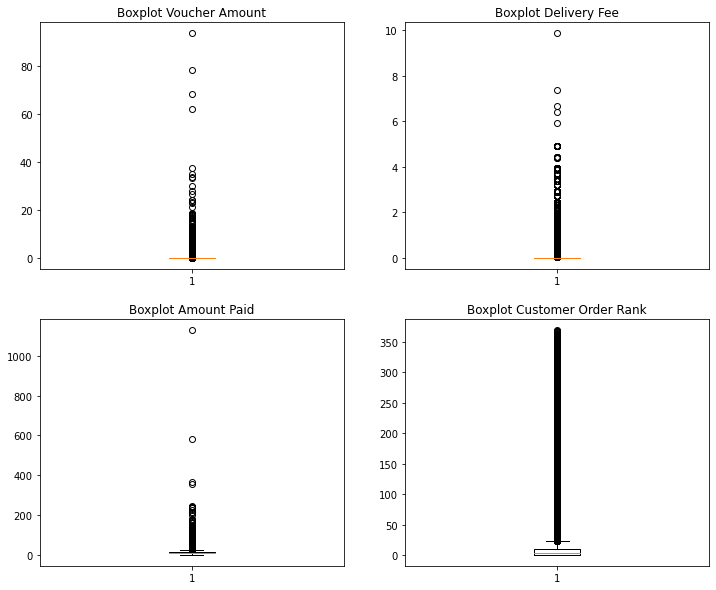

In [245]:
# Ploting boxplots for relevant numerical variables in order data
fig, axs = plt.subplots(2, 2, figsize=(12,10))
axs[0, 0].boxplot(df_order['voucher_amount'])
axs[0, 0].set_title('Boxplot Voucher Amount')
axs[0, 1].boxplot(df_order['delivery_fee'])
axs[0, 1].set_title('Boxplot Delivery Fee')
axs[1, 0].boxplot(df_order['amount_paid'])
axs[1, 0].set_title('Boxplot Amount Paid')
axs[1, 1].boxplot(df_order['customer_order_rank'][~df_order['customer_order_rank'].isnull()])
axs[1, 1].set_title('Boxplot Customer Order Rank')

Amount paid is greater than 500 in two cases,but they may not be an outlier. It may be an order on **special occasion** like 
Birthday Party, Anniversary etc when people order in large quantities, so we are not categorizing it as Outlier. **We don't find any outlier in voucher_amount, delivery_fee, amount_paid and customer order rank**. All are in reasonable range.

#### Deciding Time Range of Order Data <a class="anchor" id="section_3_1_7"></a>

#### Trend of Orders with Time <a class="anchor" id="section_3_1_6"></a> 

Text(0, 0.5, 'Number of Orders')

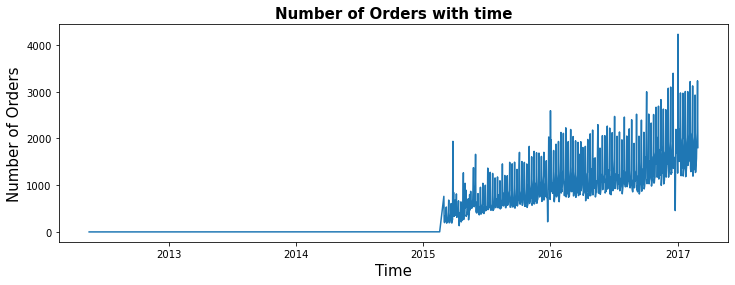

In [246]:
# trend of orders with respect to time (i.e. number of orders each day)
df_orders_by_time = df_order.groupby(['order_date'], as_index = False).size().reset_index(name='count')
plt.figure(figsize=(12,4))
plt.plot(df_orders_by_time['order_date'],df_orders_by_time['count'])
plt.title('Number of Orders with time', fontsize = 15, fontweight='bold' )
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Number of Orders', fontsize = 15)

We need to choose time-frame for our orders data. From above graph, We can see that there are negligible orders before **March 2015**. We need to exactly find this date after which significant orders started. From EDA, we can say that let's take starting date of data at which first time we received atlleast 100 orders.

In [247]:
# find date after which significant orders started
starting_date = df_orders_by_time.loc[df_orders_by_time['count'] > 100,:].reset_index()['order_date'][0]
print('Date after which significant orders started (actual starting date of order data) : {}'.format(starting_date))

Date after which significant orders started (actual starting date of order data) : 2015-03-01 00:00:00


Text(0, 0.5, 'Number of Orders')

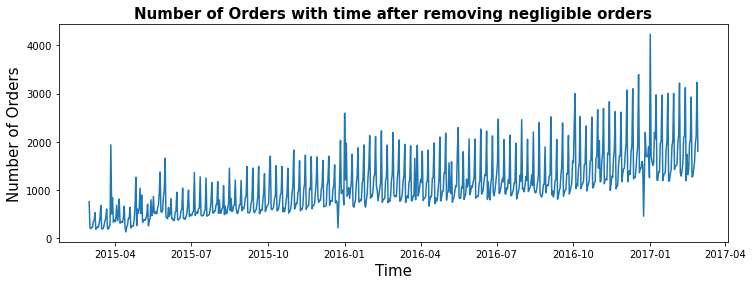

In [248]:
# remove data points before 2015-03-01
df_order = df_order.loc[df_order['order_date'] >= starting_date,:]
# Let's see how number of orders with time look like
df_orders_by_time = df_order.groupby(['order_date'], as_index = False).size().reset_index(name='count')
plt.figure(figsize=(12,4))
plt.plot(df_orders_by_time['order_date'],df_orders_by_time['count'])
plt.title('Number of Orders with time after removing negligible orders', fontsize = 15, fontweight='bold' )
plt.xlabel('Time', fontsize = 15)
plt.ylabel('Number of Orders', fontsize = 15)

####  Distribution of total number of orders by each customer

Text(0, 0.5, 'Count of customers')

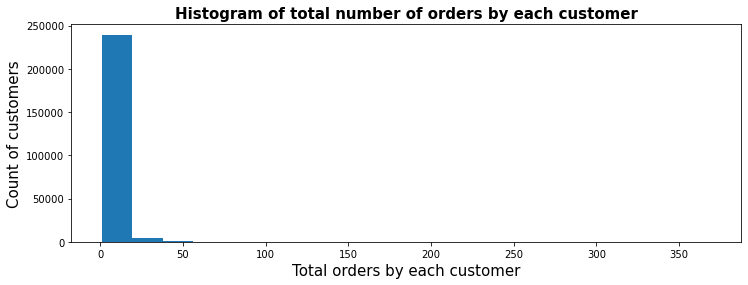

In [249]:
# Distribution of total number of orders by each customer
df_num_orders_by_customers = df_order.groupby(['customer_id'],as_index=False).agg({'customer_order_rank':[max]})
df_num_orders_by_customers.columns = ['customer_id','total_num_of_orders']
plt.figure(figsize=(12,4))
plt.hist(df_num_orders_by_customers['total_num_of_orders'], bins = 20)
plt.title('Histogram of total number of orders by each customer', fontsize = 15, fontweight='bold' )
plt.xlabel('Total orders by each customer', fontsize = 15)
plt.ylabel('Count of customers', fontsize = 15)

As expected, We can see that most of the customers has **ordered less than 20 orders** during 1st March, 2015 to 27th Feb, 2017.

####  Distribution of total amount paid by each customer

Text(0, 0.5, 'Count of customers')

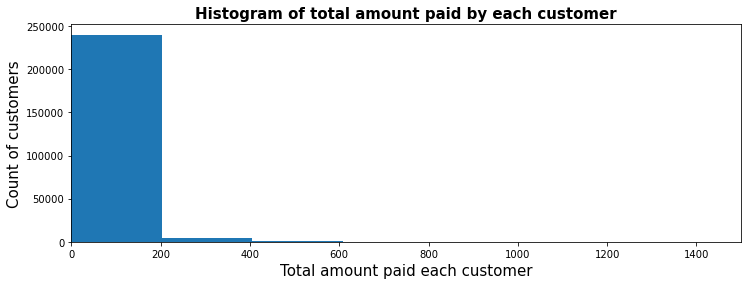

In [250]:
df_amount_paid_by_customers = df_order.groupby(['customer_id'],as_index=False).agg({'amount_paid':sum})
df_amount_paid_by_customers.columns = ['customer_id','total_amount_paid']
plt.figure(figsize=(12,4))
plt.hist(df_amount_paid_by_customers['total_amount_paid'], bins = 30)
plt.xlim([0, 1500])
plt.title('Histogram of total amount paid by each customer', fontsize = 15, fontweight='bold' )
plt.xlabel('Total amount paid each customer', fontsize = 15)
plt.ylabel('Count of customers', fontsize = 15)

### Basic Details of Labeled Data <a class="anchor" id="section_3_2"></a>

In [251]:
# get glimpse of labeled data
print(df_labeled.shape)
df_labeled.head()

(245455, 2)


,customer_id,is_returning_customer
0,000097eabfd9,0
1,0000e2c6d9be,0
2,000133bb597f,1
3,00018269939b,0
4,0001a00468a6,0


In [252]:
# number of unique customer ids in labeled data
len(df_labeled['customer_id'].unique())

245455

number of customers returning/non-returning: 
0    189948
1     55507
Name: is_returning_customer, dtype: int64



Text(0, 0.5, 'Fraction')

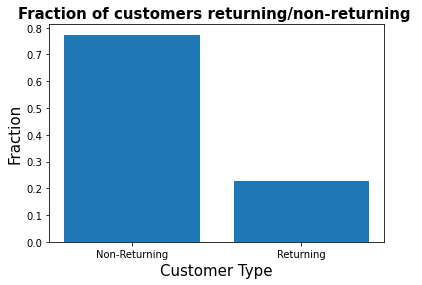

In [253]:
# number of customers returning/non-returning
print('number of customers returning/non-returning: \n{}\n'.format(df_labeled['is_returning_customer'].value_counts()))
#print('Fraction of customers returning/non-returning: \n{}'.format(df_labeled['is_returning_customer'].value_counts()/len(df_labeled['is_returning_customer'])))
plt.bar(['Non-Returning','Returning'],df_labeled['is_returning_customer'].value_counts()/len(df_labeled['is_returning_customer']))
plt.title('Fraction of customers returning/non-returning ', fontsize = 15, fontweight='bold' )
plt.xlabel('Customer Type', fontsize = 15)
plt.ylabel('Fraction', fontsize = 15)

 ## Feature Engineering <a class="anchor" id="section_4"></a>

### Removing Failed Orders before Feature Engineering <a class="anchor" id="section_4_1"></a>

In [254]:
# Removing failed orders
df_successful_orders = df_order.loc[df_order['is_failed'] == 0,:]

### Creating New Features <a class="anchor" id="section_4_2"></a>

#### Total number of orders by each customer(Frequency (F) ) <a class="anchor" id="section_4_2_1"></a> 

In [255]:
# total orders by each customer
df_total_orders = df_successful_orders.groupby(['customer_id'],as_index = False).agg({'customer_order_rank':[max]}) 
df_total_orders.columns = ['customer_id','total_orders']
# merging df_total_orders with df_labeled data
df_labeled = df_labeled.merge(df_total_orders, on = ['customer_id'], how = 'left')

`Check if percentage of returning customers is correlated with total orders`

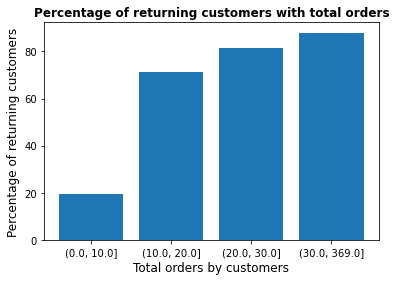

In [256]:
# creating bins of total orders
bins = [0, 10, 20, 30, max(df_labeled['total_orders'])]
temp_df = df_labeled.copy()
temp_df['total_order_bins'] = pd.cut(temp_df['total_orders'], bins)
# bar plot 
perc_return_customers(temp_df, 'total_order_bins',bins,"Percentage of returning customers with total orders",
'Total orders by customers','Percentage of returning customers','manual',fontsize=12)

`Above plot shows that Customers with higher number of total orders, have higher tendency to return. Total orders is a relevant/significant predictor`

#### Total Order Value by Each Customer <a class="anchor" id="section_4_2_2"></a> 
`Check if percentage of returning customers is correlated with Total Order Value`

In [257]:
# total amount paid by each customer
df_total_amount_paid = df_successful_orders.groupby(['customer_id'],as_index = False).agg({'amount_paid':sum})
df_total_amount_paid = df_total_amount_paid.rename({'amount_paid':'total_amount_paid'},axis=1)
df_labeled = df_labeled.merge(df_total_amount_paid,on=['customer_id'], how = 'left')

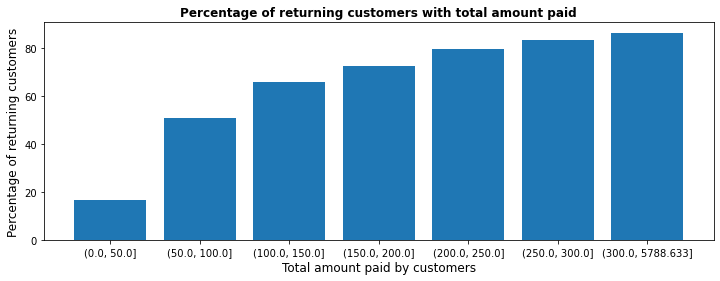

In [258]:
# creating bins of total orders
bins = [0, 50, 100, 150, 200 , 250, 300, max(df_labeled['total_amount_paid'])]
temp_df = df_labeled.copy()
temp_df['total_amount_paid_bins'] = pd.cut(temp_df['total_amount_paid'], bins)
# bar plot 
plt.figure(figsize=(12,4))
perc_return_customers(temp_df, 'total_amount_paid_bins',bins,"Percentage of returning customers with total amount paid",
'Total amount paid by customers','Percentage of returning customers','manual',fontsize=12)

`Above plot shows that Customers with higher total amount paid, have higher tendency to return. Total amount paid is a relevant/significant predictor`

#### Total amount paid in last 180 days <a class="anchor" id="section_4_2_3"></a> 
`Check if percentage of returning customers is correlated with Total amount paid in last 180 days`

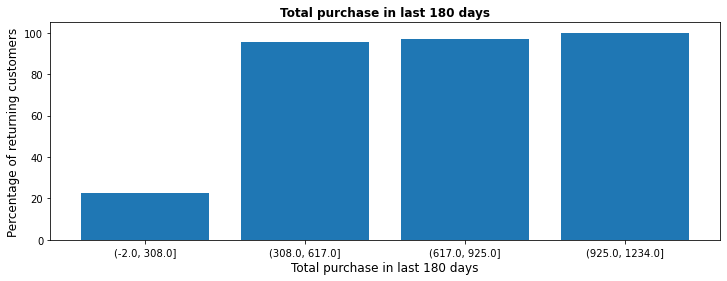

In [259]:
# Percentage of total purchase done in last 180 days
last_date = df_successful_orders['order_date'].max()
# create temporary dataframe for manipulation
temp_df = df_successful_orders.copy()
temp_df['days_before_last_date'] = (last_date - temp_df['order_date']).dt.days
temp_df = temp_df.loc[temp_df['days_before_last_date'] <= 180,:].groupby(['customer_id'],as_index=False).agg({'amount_paid':sum})
temp_df = temp_df.rename({'amount_paid':'amount_paid_in_last_180_days'},axis=1)
temp_df.fillna(0, inplace=True)
# merge with df_labeled
df_labeled = df_labeled.merge(temp_df[['customer_id','amount_paid_in_last_180_days']], on = ['customer_id'], how = 'left')
df_labeled['amount_paid_in_last_180_days'] = df_labeled['amount_paid_in_last_180_days'].fillna(0)
temp_df = df_labeled.copy()
temp_df['last_180_days_bins'] = pd.cut(temp_df['amount_paid_in_last_180_days'],4,include_lowest=True, precision=0)
# bar plot 
plt.figure(figsize=(12,4))
perc_return_customers(temp_df, 'last_180_days_bins',4,"Total purchase in last 180 days",
'Total purchase in last 180 days','Percentage of returning customers','auto',fontsize=12)

`Above plot shows that Customers with higher total amount paid in last 180 days, have higher tendency to return. Total amount paid is a relevant/significant predictor`

#### Number of unique restaurants customer ordered from <a class="anchor" id="section_4_2_5"></a> 

`Customers ordering from various restaurants may have higher likelihood of returning. Let's check`

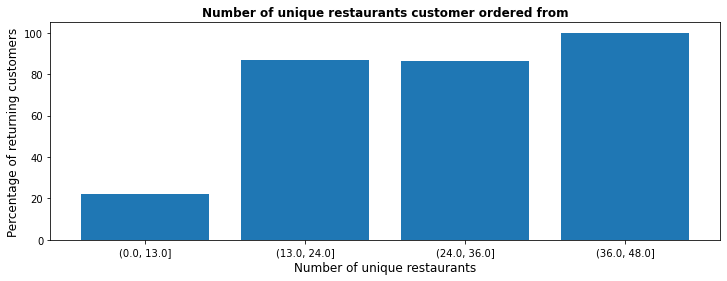

In [260]:
temp_df = df_successful_orders.groupby(['customer_id','restaurant_id'], as_index=False).agg({'order_date':'count'})
temp_df = temp_df.groupby(['customer_id'],as_index=False).size().reset_index(name='count')
temp_df.columns = ['customer_id','num_unique_restaurants']
df_labeled = df_labeled.merge(temp_df,on=['customer_id'],how = 'left')
temp_df1 = df_labeled.copy()
# creating bins for bar plot
temp_df1['num_unique_restaurants_bins'] = pd.cut(temp_df1['num_unique_restaurants'],4,include_lowest=True, precision=0)
# bar plot 
plt.figure(figsize=(12,4))
perc_return_customers(temp_df1, 'num_unique_restaurants_bins',4,"Number of unique restaurants customer ordered from",
'Number of unique restaurants','Percentage of returning customers','auto',fontsize=12)

`From Above plot, we can say that customers who orders from many different restaurants, have higher changes of returning. Numer of unique restaurants is relevant/significant predictor`

#### Recency, Customer Maturity, Percentage of spending in 2nd half <a class="anchor" id="section_4_2_6"></a> 
**Recency (R)** as days since last purchase: How many days ago was their last order? Deduct most recent order date from last date of dataset to calculate the recency value. 1 day ago? 14 days ago? 500 days ago?<br>
**Customer Maturity** : Number of days between first order and last date of our data<br>
**Percentage of spending in 2nd half** : Percentage of spending in 2nd half of a customer is total_amount_paid in 2nd half(m2) divided by total amount paid.

Calculating **Recency(R)** and **Customer Maturity**

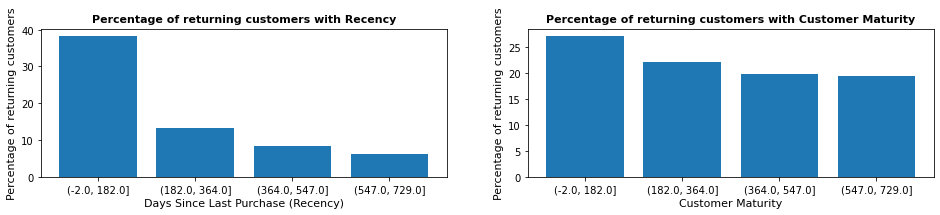

In [261]:
# calculating Recency (R),Customer Maturity and Relative change in spending in 2nd half
temp_df = df_successful_orders.copy() # create temporary copy to do manipulation
temp_df['days_since_last_purchase'] = (last_date - temp_df['order_date']).dt.days
temp_df = temp_df.groupby(['customer_id'],as_index = False).agg({'days_since_last_purchase':[min,max]})
temp_df.columns = ['customer_id','recency','customer_maturity']
df_labeled = df_labeled.merge(temp_df, on = ['customer_id'], how= 'left')
temp_df = temp_df.merge(df_labeled[['customer_id','is_returning_customer']],on = ['customer_id'], how= 'inner')
# creating bins of recency
temp_df['recency_bins'] = pd.cut(temp_df['recency'],4,include_lowest=True,precision=0 )
# creating bins of customer maturity
temp_df['customer_maturity_bins'] = pd.cut(temp_df['customer_maturity'],4,include_lowest=True,precision=0 )
# bar plot 
plt.figure(figsize=(16,6))
plt.subplot(221,autoscaley_on = True)
perc_return_customers(temp_df, 'recency_bins',4,"Percentage of returning customers with Recency",
'Days Since Last Purchase (Recency)','Percentage of returning customers','auto',fontsize=11)
plt.subplot(222,autoscaley_on = True)
perc_return_customers(temp_df, 'customer_maturity_bins',4,"Percentage of returning customers with Customer Maturity",
'Customer Maturity','Percentage of returning customers','auto',fontsize=11)

`From above plots, we can see that (1) customrs with recent purchases are more likely to return (2) New customers (low maturity) as more likely to return as compared to more mature customers`

Calculating **Percentage of spending in 2nd half**

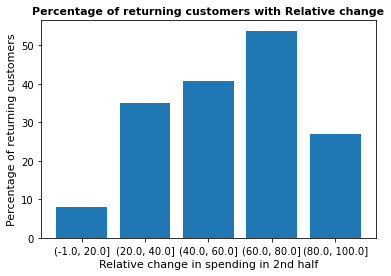

In [262]:
# calculating Percentage of spending in 2nd half
df_change = Percentage_spending_2nd_half(df_successful_orders,starting_date,last_date) #calculate change
df_labeled = df_labeled.merge(df_change[['customer_id','perc_amount_paid_2nd_half']],on=['customer_id'],how='left')
temp_df = df_labeled.copy()
temp_df['change_bins'] = pd.cut(temp_df['perc_amount_paid_2nd_half'],5,include_lowest=True,precision=0 ) # create bins
#create bar plot
perc_return_customers(temp_df, 'change_bins',5,"Percentage of returning customers with Relative change",
'Relative change in spending in 2nd half','Percentage of returning customers','auto',fontsize=11)

`From Above plot, We can say that people who spend more in 2nd half relative to 1st half, have more chances to return. 
Relative change in 2nd half is relevant/signifant predictor`

#### Maximum, Mean, Median Value of Orders <a class="anchor" id="section_4_2_7"></a> 

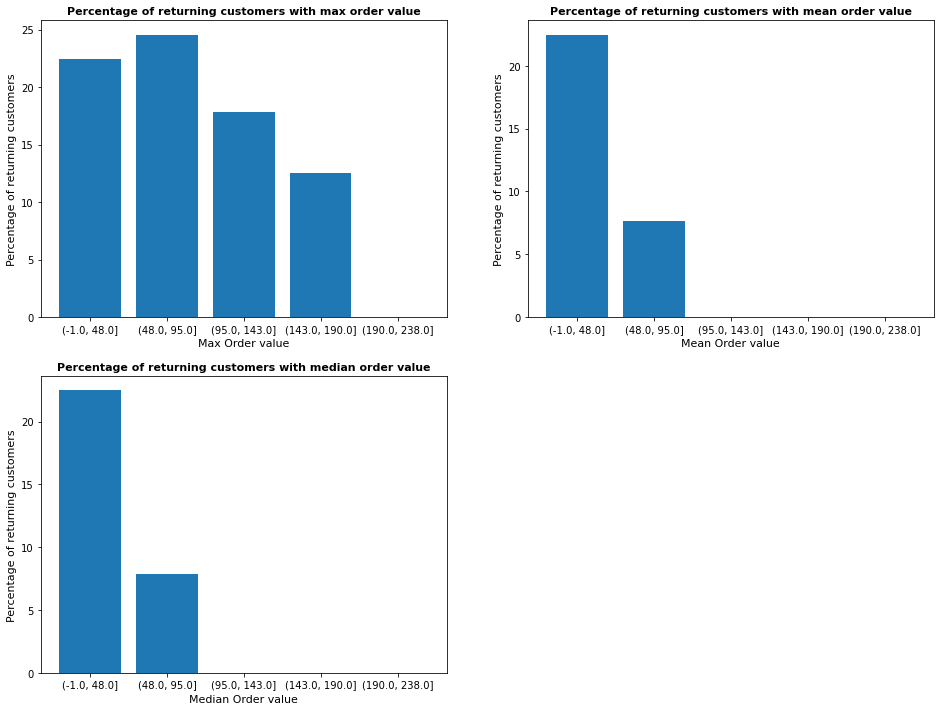

In [263]:
df_max_meam_median = df_successful_orders.groupby(['customer_id'],as_index=False).agg({'amount_paid':[max,'mean','median']})
df_max_meam_median.columns = ['customer_id','max','mean','median']
df_labeled = df_labeled.merge(df_max_meam_median,on=['customer_id'],how='left')
df_max_meam_median = df_labeled.copy() 
df_max_meam_median['max_bins'] = pd.cut(df_max_meam_median['max'],5,include_lowest=True,precision=0 )
plt.figure(figsize=(16,12))
plt.subplot(221,autoscaley_on = True)
perc_return_customers(df_max_meam_median, 'max_bins',5,"Percentage of returning customers with max order value",
'Max Order value','Percentage of returning customers','auto',fontsize=11)
df_max_meam_median['mean_bins'] = pd.cut(df_max_meam_median['mean'],5,include_lowest=True,precision=0 )
plt.subplot(222,autoscaley_on = True)
perc_return_customers(df_max_meam_median, 'mean_bins',5,"Percentage of returning customers with mean order value",
'Mean Order value','Percentage of returning customers','auto',fontsize=11)
df_max_meam_median['median_bins'] = pd.cut(df_max_meam_median['median'],5,include_lowest=True,precision=0 )
plt.subplot(223,autoscaley_on = True)
perc_return_customers(df_max_meam_median, 'median_bins',5,"Percentage of returning customers with median order value",
'Median Order value','Percentage of returning customers','auto',fontsize=11)
plt.subplots_adjust(wspace = 0.2,hspace = 0.2)

#### Customer Segmentation into Single Order,Normal,Attrition,At-Risk,Lost <a class="anchor" id="section_4_2_8"></a> 

`We will segment customers into single_order, normal, attrition, at_risk, lost based on their mean time units between orders and standard deviation of time units between orders as described below.
only single purchase in dataset: single_order customer
time since last order <= mean + 2*sd : Normal customer
mean + 2*sd < time since last order <= mean + 4*sd : attrition customer
mean + 4*sd < time since last order <= mean + 8*sd : at_risk customer
time since last order > mean + 8*sd : lost customer`

In [264]:
%%capture
df_cust_classification = customer_classification(df_successful_orders)
# merging customer classification with labeled data
df_labeled = df_labeled.merge(df_cust_classification,on=['customer_id'], how = 'left')
# calculating percentage of returning customers by each segment of customers
temp_df = df_labeled.groupby(['customer_type'],as_index=False).agg({'customer_id':'count','is_returning_customer':'sum'})
temp_df['perc_returning_cust'] = (temp_df['is_returning_customer']/temp_df['customer_id'])*100
temp_df.sort_values(['perc_returning_cust'],ascending=False,inplace=True)

Text(0.5, 1.0, 'Percentage of returning customers in ')

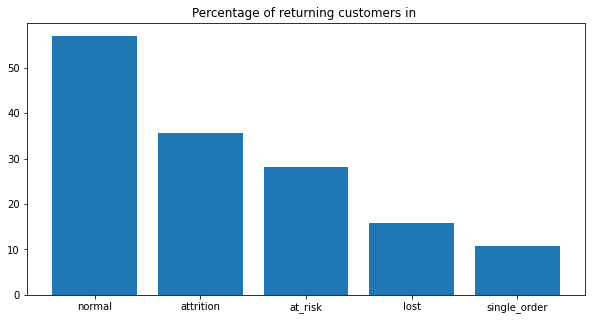

In [265]:
# plotting bar plot
plt.figure(figsize=(10,5))
plt.bar(temp_df['customer_type'],temp_df['perc_returning_cust'])
plt.title('Percentage of returning customers in ')

`From above plot, we can see that single order and lost customers have minimum chances to return. Customer with attrition and at_risk also have changes to not-return. Customer classification is relevant/significant predictor for our model`.

 ## Check if id columns correlated with Customer Return <a class="anchor" id="section_5"></a>

In [266]:
# check of Payment Id is correlated with Customer return
print(perc_return_cust_by_ids(df_successful_orders,'payment_id'))
print(perc_return_cust_by_ids(df_successful_orders,'platform_id'))
print(perc_return_cust_by_ids(df_successful_orders,'transmission_id'))

   payment_id  total_num_customers  num_return_customers  return_perc
0        1491                 9841                  2130    21.644142
1        1523                  449                   210    46.770601
2        1619               166629                 35072    21.047957
3        1779                60989                 15874    26.027644
4        1811                 7027                  1731    24.633556
    platform_id  total_num_customers  num_return_customers  return_perc
0           525                  705                    48     6.808511
1         22167                    1                     0     0.000000
2         22263                   68                     4     5.882353
3         22295                    1                     1   100.000000
4         29463                86218                 18441    21.388805
5         29495                 5664                   879    15.519068
6         29751                 4483                  1326    29.578407
7   

`From above tables, We can say that Payment id, platform_id and transmission id doesn't have any correlation with likelihood of Customer Return. They are is not relevant predictors.`

(245455, 13)